In [13]:
# Import required libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
import warnings
from datetime import datetime
import logging
from tqdm import tqdm
from scipy import stats
from sklearn.preprocessing import StandardScaler
import networkx as nx

# Configure logging
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_file = f'../reports/volatility_analysis_{timestamp}.log'
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(log_file),
        logging.StreamHandler()
    ]
)

# Suppress warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("darkgrid")
sns.set_palette("husl", n_colors=11)  # One color per sector

# Customize plot appearance
plt.rcParams.update({
    'figure.figsize': [15, 8],
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.grid.axis': 'both',
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#CCCCCC',
    'grid.alpha': 0.5,
    'font.size': 12,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'legend.frameon': True,
    'legend.framealpha': 0.8,
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.right': False,
    'axes.spines.top': False
})

# Create necessary directories
for dir_path in [
    '../data/volatility',
    '../reports/figures/sectors',
    '../reports/figures/volatility'
]:
    Path(dir_path).mkdir(parents=True, exist_ok=True)

# Model configuration
MODEL_CONFIG = {
    'window_size': 60,    # Reduced window size for faster computation
    'garch_p': 1,         # GARCH lag order
    'garch_q': 1,         # ARCH lag order
    'dist': 'Normal',     # Simpler distribution for faster computation
    'vol_cutoff': 50.0,   # Maximum allowed volatility
    'min_window': 40,     # Reduced minimum window size
    'confidence_level': 0.95,  # For VaR and ES calculations
    'update_freq': 5      # Update every 5 days instead of daily
}

# Risk metrics configuration
RISK_CONFIG = {
    'var_level': 0.95,    # Value at Risk confidence level
    'es_level': 0.975,    # Expected Shortfall confidence level
    'regime_threshold': 2  # Standard deviations for regime detection
}

# Define key market events
KEY_EVENTS = {
    'COVID-19 Crash': '2020-03-23',
    'Fed First Hike': '2022-03-16',
    'Tech Selloff': '2022-01-03',
    'SVB Collapse': '2023-03-10',
    'AI Rally Start': '2023-11-01',
    'Rate Peak': '2023-07-26'
}

# Define sector colors for consistent plotting
SECTOR_COLORS = {
    'Technology': '#2ecc71',
    'Healthcare': '#3498db',
    'Financials': '#9b59b6',
    'Consumer_Discretionary': '#e74c3c',
    'Consumer_Staples': '#f1c40f',
    'Energy': '#e67e22',
    'Industrials': '#1abc9c',
    'Materials': '#34495e',
    'Real_Estate': '#95a5a6',
    'Utilities': '#7f8c8d',
    'Communication_Services': '#d35400'
}

logging.info("Configuration complete. Starting volatility analysis with enhanced risk metrics.")


2025-07-26 23:20:36,058 - INFO - Configuration complete. Starting volatility analysis with enhanced risk metrics.


In [14]:
# Function to calculate risk metrics
def calculate_risk_metrics(returns: pd.Series, volatility: pd.Series, config: dict) -> dict:
    """
    Calculate various risk metrics from return series.
    
    Args:
        returns (pd.Series): Log returns
        volatility (pd.Series): GARCH volatility estimates
        config (dict): Risk configuration parameters
        
    Returns:
        dict: Dictionary of risk metrics
    """
    metrics = {}
    
    # Clean data
    clean_returns = returns.dropna()
    clean_volatility = volatility.dropna()
    
    if len(clean_returns) > 0:
        # Value at Risk
        var = np.percentile(clean_returns, (1 - config['var_level']) * 100)
        metrics['VaR'] = float(abs(var))  # Convert to float to avoid nan
        
        # Expected Shortfall
        tail_returns = clean_returns[clean_returns <= var]
        metrics['ES'] = float(abs(tail_returns.mean()))  # Convert to float
    else:
        metrics['VaR'] = 0.0
        metrics['ES'] = 0.0
    
    if len(clean_volatility) > 0:
        # Volatility regime
        vol_mean = clean_volatility.mean()
        vol_std = clean_volatility.std()
        high_vol = clean_volatility > (vol_mean + config['regime_threshold'] * vol_std)
        metrics['High_Vol_Days'] = int(high_vol.sum())  # Convert to int
        metrics['High_Vol_Pct'] = float(high_vol.mean() * 100)  # Convert to float
    else:
        metrics['High_Vol_Days'] = 0
        metrics['High_Vol_Pct'] = 0.0
    
    # Distribution statistics
    clean_returns = clean_returns[np.isfinite(clean_returns)]  # Remove inf values
    if len(clean_returns) > 0:
        metrics.update({
            'Skewness': float(stats.skew(clean_returns)),
            'Kurtosis': float(stats.kurtosis(clean_returns)),
            'Jarque_Bera': float(stats.jarque_bera(clean_returns)[0])
        })
    else:
        metrics.update({
            'Skewness': 0.0,
            'Kurtosis': 0.0,
            'Jarque_Bera': 0.0
        })
    
    return metrics

# Function to fit GARCH model with enhanced features
def fit_garch_model(data: pd.DataFrame, sector: str, config: dict) -> tuple:
    """
    Calculate log returns and fit GARCH(1,1) model with enhanced features.
    
    Args:
        data (pd.DataFrame): DataFrame with price data
        sector (str): Sector name for logging
        config (dict): Model configuration parameters
        
    Returns:
        tuple: (results DataFrame, risk metrics dict)
    """
    try:
        # Calculate log returns using Close price
        log_returns = 100 * np.log(data['Close'] / data['Close'].shift(1))
        
        # Initialize result series
        garch_vol = pd.Series(index=data.index, dtype=float)
        arch_vol = pd.Series(index=data.index, dtype=float)
        var_series = pd.Series(index=data.index, dtype=float)
        es_series = pd.Series(index=data.index, dtype=float)
        
        # Fit GARCH model using rolling windows with reduced frequency
        for i in range(config['window_size'], len(data), config['update_freq']):
            window_returns = log_returns.iloc[i-config['window_size']:i]
            
            try:
                # Clean and validate window data
                window_returns = window_returns.replace([np.inf, -np.inf], np.nan).dropna()
                
                if not np.all(np.isfinite(window_returns)) or len(window_returns) < config['min_window']:
                    continue
                
                # Fit GARCH model
                model = arch_model(
                    window_returns,
                    p=config['garch_p'],
                    q=config['garch_q'],
                    dist=config['dist']
                )
                result = model.fit(disp='off')
                
                # Get volatility estimates
                vol = result.conditional_volatility[-1]
                if vol < config['vol_cutoff']:  # Skip extreme values
                    garch_vol.iloc[i] = vol
                    arch_vol.iloc[i] = result.resid[-1]
                    
                    # Calculate rolling VaR and ES
                    var_series.iloc[i] = abs(np.percentile(window_returns, 
                                                         (1 - config['confidence_level']) * 100))
                    es_series.iloc[i] = abs(window_returns[window_returns <= var_series.iloc[i]].mean())
                
            except Exception as e:
                logging.debug(f"Window fit error for {sector} at {i}: {str(e)}")
                continue
        
        # Create results DataFrame
        results = pd.DataFrame({
            'Date': data.index,
            'Close': data['Close'],
            'Log_Return': log_returns,
            'Volatility_GARCH': garch_vol,
            'Volatility_ARCH': arch_vol,
            'VaR': var_series,
            'ES': es_series
        })
        
        # Calculate overall risk metrics
        risk_metrics = calculate_risk_metrics(log_returns, garch_vol, RISK_CONFIG)
        
        return results, risk_metrics
    
    except Exception as e:
        logging.error(f"Error processing {sector}: {str(e)}")
        return None, None

# Function to plot enhanced volatility analysis
def plot_volatility(results: pd.DataFrame, risk_metrics: dict, sector: str):
    """
    Create enhanced volatility analysis plots.
    
    Args:
        results (pd.DataFrame): DataFrame with returns and risk metrics
        risk_metrics (dict): Dictionary of risk metrics
        sector (str): Sector name for plot titles
    """
    try:
        # Clean sector name for file paths
        sector_file_name = sector.replace(' ', '_')
        
        # Create figure and grid
        fig = plt.figure(figsize=(15, 12))
        gs = plt.GridSpec(3, 1, height_ratios=[1, 1.5, 1], hspace=0.4)
        
        # Plot 1: Log Returns
        ax1 = fig.add_subplot(gs[0])
        ax1.plot(results['Date'], results['Log_Return'], 
                label='Log Returns', alpha=0.6, color='gray', linewidth=1)
        ax1.set_title(f'{sector} - Daily Log Returns', fontsize=12)
        ax1.set_ylabel('Log Return (%)')
        
        # Add VaR bands
        ax1.fill_between(results['Date'], 
                        -results['VaR'], results['VaR'],
                        color='blue', alpha=0.1, 
                        label=f'VaR ({RISK_CONFIG["var_level"]*100}%)')
        ax1.legend()
        
        # Plot 2: GARCH Volatility
        ax2 = fig.add_subplot(gs[1])
        ax2.plot(results['Date'], results['Volatility_GARCH'],
                label='GARCH(1,1)', color='blue', linewidth=2)
        ax2.plot(results['Date'], results['ES'],
                label='Expected Shortfall', color='red', linestyle='--', alpha=0.6)
        ax2.set_title(f'{sector} - Volatility and Risk Metrics', fontsize=12)
        ax2.set_ylabel('Volatility / Risk')
        
        # Add volatility regime bands
        vol_mean = results['Volatility_GARCH'].mean()
        vol_std = results['Volatility_GARCH'].std()
        ax2.axhline(y=vol_mean + RISK_CONFIG['regime_threshold'] * vol_std,
                    color='red', linestyle=':', alpha=0.5,
                    label='High Volatility Threshold')
        ax2.legend()
        
        # Plot 3: Rolling Risk Metrics
        ax3 = fig.add_subplot(gs[2])
        ax3.plot(results['Date'], results['VaR'].rolling(30).mean(),
                label='30-day VaR', color='purple', alpha=0.7)
        ax3.plot(results['Date'], results['ES'].rolling(30).mean(),
                label='30-day ES', color='orange', alpha=0.7)
        ax3.set_title('Rolling Risk Metrics', fontsize=12)
        ax3.set_ylabel('Risk Level')
        ax3.legend()
        
        # Add key events as vertical lines
        for event, date in KEY_EVENTS.items():
            event_date = pd.to_datetime(date)
            if event_date in results['Date'].values:  # Check values instead of index
                for ax in [ax1, ax2, ax3]:
                    ax.axvline(x=event_date, color='gray', 
                            linestyle='--', alpha=0.3)
                    if ax == ax2:  # Add labels only to middle plot
                        ax.text(event_date, ax.get_ylim()[1], event,
                            rotation=90, verticalalignment='top',
                            fontsize=10, alpha=0.7)
        
        # Add risk metrics summary
        summary_text = (
            f"Risk Metrics Summary:\n"
            f"VaR ({RISK_CONFIG['var_level']*100}%): {risk_metrics['VaR']:.2f}%\n"
            f"ES ({RISK_CONFIG['es_level']*100}%): {risk_metrics['ES']:.2f}%\n"
            f"High Vol Days: {risk_metrics['High_Vol_Days']} ({risk_metrics['High_Vol_Pct']:.1f}%)\n"
            f"Skewness: {risk_metrics['Skewness']:.2f}\n"
            f"Kurtosis: {risk_metrics['Kurtosis']:.2f}"
        )
        
        plt.figtext(0.02, 0.02, summary_text, fontsize=10,
                    bbox=dict(facecolor='white', alpha=0.8))
        
        # Adjust layout and save
        plt.tight_layout()
        save_path = f'../reports/figures/sectors/{sector_file_name}_volatility.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
        
        return True
        
    except Exception as e:
        logging.error(f"Error in plot_volatility for {sector}: {str(e)}")
        plt.close()  # Make sure to close the figure even if there's an error
        return False

# Get list of sector files
sector_files = list(Path('../data/sectors').glob('*.csv'))
logging.info(f"Found {len(sector_files)} sector ETF files")


2025-07-26 23:20:36,120 - INFO - Found 11 sector ETF files


In [15]:
# Process each sector ETF
sector_results = {}
sector_risk_metrics = {}

# Map sector ETF tickers to full names
SECTOR_NAMES = {
    'XLB': 'Materials',
    'XLC': 'Communication Services',
    'XLE': 'Energy',
    'XLF': 'Financials',
    'XLI': 'Industrials',
    'XLK': 'Information Technology',
    'XLP': 'Consumer Staples',
    'XLRE': 'Real Estate',
    'XLU': 'Utilities',
    'XLV': 'Healthcare',
    'XLY': 'Consumer Discretionary'
}

for file_path in tqdm(sector_files, desc="Processing sectors", ncols=80):
    try:
        # Extract sector ETF ticker from file path
        sector_etf = file_path.stem
        sector_name = SECTOR_NAMES.get(sector_etf, sector_etf)
        logging.info(f"Processing {sector_etf} sector ({sector_name})")
        
        # Read data
        df = pd.read_csv(file_path)
        df['Date'] = pd.to_datetime(df['Date'], utc=True)
        df = df.set_index('Date')
        
        # Fit GARCH model and get results
        results, risk_metrics = fit_garch_model(df, sector_name, MODEL_CONFIG)
        
        if results is not None and risk_metrics is not None:
            # Store results using sector name
            sector_results[sector_name] = results
            sector_risk_metrics[sector_name] = risk_metrics
            
            # Save results using ETF ticker
            output_path = f'../data/volatility/{sector_etf}_garch.csv'
            results.to_csv(output_path, index=False)
            logging.info(f"Saved results to {output_path}")
            
            try:
                # Create plots
                plot_volatility(results, risk_metrics, sector_name)
                logging.info(f"Created volatility plot for {sector_name}")
            except Exception as plot_error:
                logging.error(f"Error creating plot for {sector_name}: {str(plot_error)}")
            
            # Print summary statistics
            print(f"\n{sector_name} Sector Risk Analysis:")
            print(f"- VaR ({RISK_CONFIG['var_level']*100}%): {risk_metrics['VaR']:.2f}%")
            print(f"- ES ({RISK_CONFIG['es_level']*100}%): {risk_metrics['ES']:.2f}%")
            print(f"- High Volatility Days: {risk_metrics['High_Vol_Days']} ({risk_metrics['High_Vol_Pct']:.1f}%)")
            print(f"- Distribution: Skew={risk_metrics['Skewness']:.2f}, Kurt={risk_metrics['Kurtosis']:.2f}")
            
            # Analyze key events
            print(f"\nKey Event Analysis:")
            for event, date in KEY_EVENTS.items():
                event_date = pd.to_datetime(date)
                if event_date in results.index:
                    vol = results.loc[event_date, 'Volatility_GARCH']
                    var = results.loc[event_date, 'VaR']
                    print(f"  * {event}:")
                    print(f"    - Volatility: {vol:.2f}%")
                    print(f"    - VaR: {var:.2f}%")
        
    except Exception as e:
        logging.error(f"Error processing {sector_etf}: {str(e)}")
        continue

# Create cross-sector correlation network
if len(sector_results) > 1:
    try:
        # Calculate correlation matrix
        sector_returns = pd.DataFrame()
        for sector, results in sector_results.items():
            sector_returns[sector] = results['Log_Return']
        
        corr_matrix = sector_returns.corr()
        
        # Create and plot correlation network
        plt.figure(figsize=(15, 15))
        G = nx.Graph()
        
        # Add nodes and edges
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                corr = corr_matrix.iloc[i, j]
                if abs(corr) > 0.5:  # Only show strong correlations
                    G.add_edge(corr_matrix.columns[i], 
                             corr_matrix.columns[j], 
                             weight=abs(corr))
        
        # Set node colors and sizes
        node_colors = [SECTOR_COLORS.get(sector, '#333333') for sector in G.nodes()]
        node_sizes = [3000 for _ in G.nodes()]
        
        # Draw network
        pos = nx.spring_layout(G)
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
        
        # Draw edges with varying thickness based on correlation
        edge_weights = [G[u][v]['weight'] * 2 for u, v in G.edges()]
        nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.3)
        
        # Add labels
        nx.draw_networkx_labels(G, pos)
        
        plt.title('Sector Return Correlation Network', fontsize=14, pad=20)
        plt.axis('off')
        plt.savefig('../reports/figures/volatility/sector_correlations.png', 
                    dpi=300, bbox_inches='tight')
        plt.close()
        
        # Create correlation heatmap
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', 
                   center=0, fmt='.2f')
        plt.title('Sector Return Correlations', fontsize=14)
        plt.tight_layout()
        plt.savefig('../reports/figures/volatility/correlation_heatmap.png', 
                    dpi=300, bbox_inches='tight')
        plt.close()
        
        # Find high correlations
        strong_correlations = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                corr = corr_matrix.iloc[i, j]
                if abs(corr) > 0.7:
                    strong_correlations.append((
                        corr_matrix.columns[i],
                        corr_matrix.columns[j],
                        corr
                    ))
        
        if strong_correlations:
            print("\nStrong Sector Correlations (|r| > 0.7):")
            for sector1, sector2, corr in strong_correlations:
                print(f"- {sector1} <-> {sector2}: {corr:.3f}")
                
        # Save correlations for the summary report
        high_corr_pairs = strong_correlations
                
    except Exception as e:
        logging.error(f"Error creating correlation analysis: {str(e)}")

# Create comparative volatility plot
plt.figure(figsize=(15, 8))

# Plot volatility for each sector
for sector, results in sector_results.items():
    plt.plot(results.index, results['Volatility_GARCH'],
             label=sector, alpha=0.7, linewidth=1.5,
             color=SECTOR_COLORS.get(sector, '#333333'))

# Add key events
for event, date in KEY_EVENTS.items():
    event_date = pd.to_datetime(date)
    plt.axvline(x=event_date, color='gray', linestyle='--', alpha=0.3)
    plt.text(event_date, plt.ylim()[1], event,
             rotation=90, verticalalignment='top',
             fontsize=10, alpha=0.7)

plt.title('Sector-wise GARCH Volatility Comparison', fontsize=14, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('GARCH(1,1) Volatility', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()

plt.savefig('../reports/figures/volatility/comparative_volatility.png',
            dpi=300, bbox_inches='tight')
plt.close()

# Save summary report
with open(f'../reports/volatility_summary_{timestamp}.txt', 'w') as f:
    f.write("NASDAQ-100 Sector Volatility Analysis\n")
    f.write("=" * 50 + "\n\n")
    
    f.write("Risk Metrics by Sector:\n")
    f.write("-" * 30 + "\n")
    for sector, metrics in sector_risk_metrics.items():
        f.write(f"\n{sector}:\n")
        for metric, value in metrics.items():
            f.write(f"- {metric}: {value:.3f}\n")
    
    if high_corr_pairs:
        f.write("\nStrong Sector Correlations:\n")
        f.write("-" * 30 + "\n")
        for sector1, sector2, corr in high_corr_pairs:
            f.write(f"- {sector1} <-> {sector2}: {corr:.3f}\n")
    
    f.write("\nKey Event Analysis:\n")
    f.write("-" * 30 + "\n")
    for event, date in KEY_EVENTS.items():
        f.write(f"\n{event} ({date}):\n")
        event_date = pd.to_datetime(date)
        for sector, results in sector_results.items():
            if event_date in results.index:
                vol = results.loc[event_date, 'Volatility_GARCH']
                var = results.loc[event_date, 'VaR']
                f.write(f"- {sector}: Vol={vol:.2f}%, VaR={var:.2f}%\n")

logging.info("Enhanced volatility analysis complete")


Processing sectors:   0%|                                | 0/11 [00:00<?, ?it/s]2025-07-26 23:20:36,172 - INFO - Processing XLB sector (Materials)


2025-07-26 23:20:46,856 - INFO - Saved results to ../data/volatility/XLB_garch.csv
2025-07-26 23:20:49,351 - INFO - Created volatility plot for Materials
Processing sectors:   9%|██▏                     | 1/11 [00:13<02:11, 13.19s/it]2025-07-26 23:20:49,361 - INFO - Processing XLC sector (Communication Services)



Materials Sector Risk Analysis:
- VaR (95.0%): 1.96%
- ES (97.5%): 3.04%
- High Volatility Days: 12 (2.3%)
- Distribution: Skew=-0.41, Kurt=9.45

Key Event Analysis:


2025-07-26 23:20:56,697 - INFO - Saved results to ../data/volatility/XLC_garch.csv
2025-07-26 23:20:58,598 - INFO - Created volatility plot for Communication Services
Processing sectors:  18%|████▎                   | 2/11 [00:22<01:37, 10.87s/it]2025-07-26 23:20:58,604 - INFO - Processing XLE sector (Energy)



Communication Services Sector Risk Analysis:
- VaR (95.0%): 2.25%
- ES (97.5%): 3.55%
- High Volatility Days: 10 (2.9%)
- Distribution: Skew=-0.48, Kurt=6.88

Key Event Analysis:


2025-07-26 23:21:10,106 - INFO - Saved results to ../data/volatility/XLE_garch.csv
2025-07-26 23:21:12,386 - INFO - Created volatility plot for Energy
Processing sectors:  27%|██████▌                 | 3/11 [00:36<01:37, 12.20s/it]2025-07-26 23:21:12,392 - INFO - Processing XLF sector (Financials)



Energy Sector Risk Analysis:
- VaR (95.0%): 2.79%
- ES (97.5%): 4.40%
- High Volatility Days: 10 (1.9%)
- Distribution: Skew=-0.87, Kurt=15.52

Key Event Analysis:


2025-07-26 23:21:24,270 - INFO - Saved results to ../data/volatility/XLF_garch.csv
2025-07-26 23:21:26,339 - INFO - Created volatility plot for Financials
Processing sectors:  36%|████████▋               | 4/11 [00:50<01:30, 12.89s/it]2025-07-26 23:21:26,346 - INFO - Processing XLI sector (Industrials)



Financials Sector Risk Analysis:
- VaR (95.0%): 2.07%
- ES (97.5%): 3.33%
- High Volatility Days: 14 (2.7%)
- Distribution: Skew=-0.57, Kurt=14.92

Key Event Analysis:


2025-07-26 23:21:36,728 - INFO - Saved results to ../data/volatility/XLI_garch.csv
2025-07-26 23:21:38,700 - INFO - Created volatility plot for Industrials
Processing sectors:  45%|██████████▉             | 5/11 [01:02<01:16, 12.70s/it]2025-07-26 23:21:38,707 - INFO - Processing XLK sector (Information Technology)



Industrials Sector Risk Analysis:
- VaR (95.0%): 1.87%
- ES (97.5%): 2.97%
- High Volatility Days: 17 (3.3%)
- Distribution: Skew=-0.53, Kurt=13.72

Key Event Analysis:


2025-07-26 23:21:49,112 - INFO - Saved results to ../data/volatility/XLK_garch.csv
2025-07-26 23:21:51,542 - INFO - Created volatility plot for Information Technology
Processing sectors:  55%|█████████████           | 6/11 [01:15<01:03, 12.75s/it]2025-07-26 23:21:51,549 - INFO - Processing XLP sector (Consumer Staples)



Information Technology Sector Risk Analysis:
- VaR (95.0%): 2.41%
- ES (97.5%): 3.62%
- High Volatility Days: 13 (2.5%)
- Distribution: Skew=-0.30, Kurt=9.90

Key Event Analysis:


2025-07-26 23:22:03,408 - INFO - Saved results to ../data/volatility/XLP_garch.csv
2025-07-26 23:22:05,993 - INFO - Created volatility plot for Consumer Staples
Processing sectors:  64%|███████████████▎        | 7/11 [01:29<00:53, 13.31s/it]2025-07-26 23:22:06,000 - INFO - Processing XLRE sector (Real Estate)



Consumer Staples Sector Risk Analysis:
- VaR (95.0%): 1.34%
- ES (97.5%): 2.17%
- High Volatility Days: 11 (2.1%)
- Distribution: Skew=-0.48, Kurt=14.80

Key Event Analysis:


2025-07-26 23:22:16,201 - INFO - Saved results to ../data/volatility/XLRE_garch.csv
2025-07-26 23:22:18,596 - INFO - Created volatility plot for Real Estate
Processing sectors:  73%|█████████████████▍      | 8/11 [01:42<00:39, 13.08s/it]2025-07-26 23:22:18,603 - INFO - Processing XLU sector (Utilities)



Real Estate Sector Risk Analysis:
- VaR (95.0%): 1.91%
- ES (97.5%): 3.13%
- High Volatility Days: 10 (2.1%)
- Distribution: Skew=-1.04, Kurt=18.11

Key Event Analysis:


2025-07-26 23:22:30,410 - INFO - Saved results to ../data/volatility/XLU_garch.csv
2025-07-26 23:22:32,294 - INFO - Created volatility plot for Utilities
Processing sectors:  82%|███████████████████▋    | 9/11 [01:56<00:26, 13.27s/it]2025-07-26 23:22:32,300 - INFO - Processing XLV sector (Healthcare)



Utilities Sector Risk Analysis:
- VaR (95.0%): 1.75%
- ES (97.5%): 2.86%
- High Volatility Days: 10 (1.9%)
- Distribution: Skew=-0.31, Kurt=15.11

Key Event Analysis:


2025-07-26 23:22:42,577 - INFO - Saved results to ../data/volatility/XLV_garch.csv
2025-07-26 23:22:45,225 - INFO - Created volatility plot for Healthcare
Processing sectors:  91%|████████████████████▉  | 10/11 [02:09<00:13, 13.17s/it]2025-07-26 23:22:45,229 - INFO - Processing XLY sector (Consumer Discretionary)



Healthcare Sector Risk Analysis:
- VaR (95.0%): 1.58%
- ES (97.5%): 2.54%
- High Volatility Days: 11 (2.1%)
- Distribution: Skew=-0.43, Kurt=9.06

Key Event Analysis:


2025-07-26 23:22:56,873 - INFO - Saved results to ../data/volatility/XLY_garch.csv
2025-07-26 23:22:58,970 - INFO - Created volatility plot for Consumer Discretionary
Processing sectors: 100%|███████████████████████| 11/11 [02:22<00:00, 12.98s/it]



Consumer Discretionary Sector Risk Analysis:
- VaR (95.0%): 2.19%
- ES (97.5%): 3.36%
- High Volatility Days: 15 (2.9%)
- Distribution: Skew=-0.59, Kurt=9.18

Key Event Analysis:

Strong Sector Correlations (|r| > 0.7):
- Materials <-> Financials: 0.822
- Materials <-> Industrials: 0.883
- Materials <-> Information Technology: 0.707
- Materials <-> Consumer Discretionary: 0.742
- Communication Services <-> Industrials: 0.700
- Communication Services <-> Information Technology: 0.841
- Communication Services <-> Consumer Discretionary: 0.820
- Financials <-> Industrials: 0.879
- Financials <-> Consumer Discretionary: 0.736
- Industrials <-> Information Technology: 0.750
- Industrials <-> Healthcare: 0.719
- Industrials <-> Consumer Discretionary: 0.785
- Information Technology <-> Consumer Discretionary: 0.846
- Consumer Staples <-> Utilities: 0.703
- Consumer Staples <-> Healthcare: 0.709
- Real Estate <-> Utilities: 0.737


2025-07-26 23:23:02,553 - INFO - Enhanced volatility analysis complete


Comparative Sector Volatility Analysis

Sector Volatility Summary
--------------------------------------------------------------------------------
Sector                       Avg Vol    Max Vol     Max Date  COVID
--------------------------------------------------------------------------------
Energy                       166.85%   1528.98%   2020-03-11      ✅
Technology                   135.14%   1235.37%   2020-03-18      ✅
Financials                   123.07%   1325.07%   2020-03-18      ✅
Consumer Discretionary       121.41%   1055.79%   2020-03-18      ✅
Real Estate                  113.72%   1109.12%   2020-03-18      ✅
Industrials                  111.67%    961.05%   2020-03-18      ✅
Utilities                    105.52%   1007.94%   2020-03-19      ✅
Healthcare                    96.04%    788.00%   2020-03-18      ✅
--------------------------------------------------------------------------------


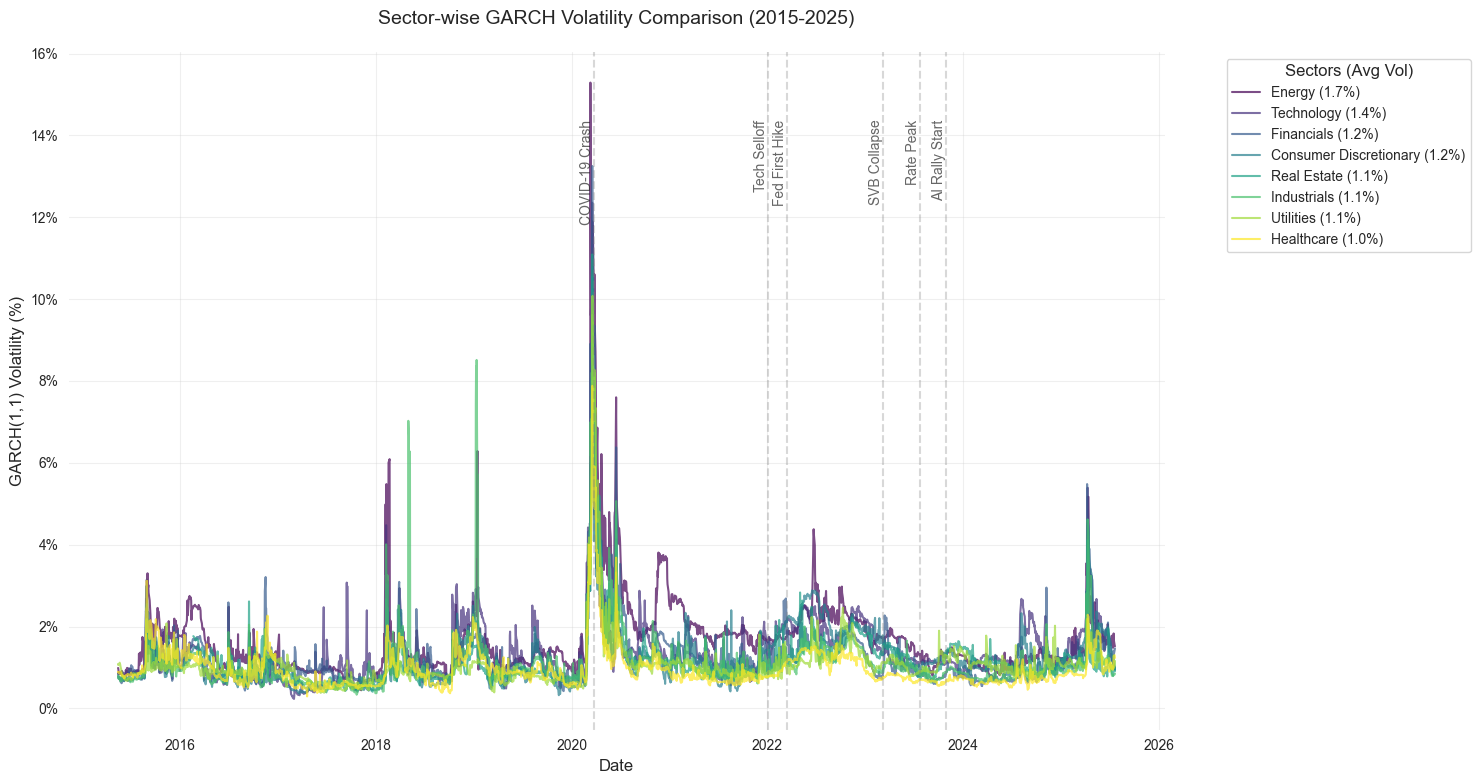


Sector Volatility Rankings:
--------------------------------------------------
Energy              :   1.67% avg,   15.29% max (2020-03-11, COVID: ✅)
Technology          :   1.35% avg,   12.35% max (2020-03-18, COVID: ✅)
Financials          :   1.23% avg,   13.25% max (2020-03-18, COVID: ✅)
Consumer Discretionary:   1.21% avg,   10.56% max (2020-03-18, COVID: ✅)
Real Estate         :   1.14% avg,   11.09% max (2020-03-18, COVID: ✅)
Industrials         :   1.12% avg,    9.61% max (2020-03-18, COVID: ✅)
Utilities           :   1.06% avg,   10.08% max (2020-03-19, COVID: ✅)
Healthcare          :   0.96% avg,    7.88% max (2020-03-18, COVID: ✅)

Key Insights:
--------------------------------------------------
1. Most Volatile Sector: Energy

2. Sector Volatility Tiers:
   High Volatility Sectors (>1.32%):
   - Energy: 1.67%
   - Technology: 1.35%

   Medium Volatility Sectors:
   - Financials: 1.23%
   - Consumer Discretionary: 1.21%
   - Real Estate: 1.14%
   - Industrials: 1.12%

   Low

In [19]:
# Load and analyze volatility results
print("Comparative Sector Volatility Analysis")
print("=" * 50)

# Dictionary to store sector data
all_results = {}
sector_metrics = []

# Load all volatility results
for file_path in Path('../data/volatility').glob('*_garch.csv'):
    try:
        # Load and process data
        sector = file_path.stem.replace('_garch', '')
        
        # Skip if this is an ETF ticker (we'll use the main sector name)
        if len(sector) <= 4 and sector.upper() == sector:
            continue
            
        df = pd.read_csv(file_path)
        df['Date'] = pd.to_datetime(df['Date'], utc=True)
        all_results[sector] = df
        
        # Calculate metrics
        avg_vol = df['Volatility_GARCH'].mean() * 100  # Convert to percentage
        max_vol = df['Volatility_GARCH'].max() * 100   # Convert to percentage
        max_date = df.loc[df['Volatility_GARCH'].idxmax(), 'Date']
        
        # Check if max spike was during COVID (March 2020)
        covid_spike = "✅" if max_date.strftime("%Y-%m") == "2020-03" else "❌"
        
        # Format sector name
        sector_name = sector.replace('_', ' ').title()
        
        # Store metrics
        sector_metrics.append({
            'Sector': sector_name,
            'Avg Volatility': avg_vol,
            'Max Volatility': max_vol,
            'Max Spike Date': max_date.strftime("%Y-%m-%d"),
            'COVID Spike': covid_spike,
            'Data Quality': "Complete" if len(df) > 100 else "Incomplete"
        })
        
    except Exception as e:
        print(f"Warning: Error processing {sector}: {str(e)}")
        continue

# Create summary table
metrics_df = pd.DataFrame(sector_metrics)
metrics_df = metrics_df.sort_values('Avg Volatility', ascending=False)

# Print formatted table
print("\nSector Volatility Summary")
print("-" * 80)
print(f"{'Sector':25s} {'Avg Vol':>10s} {'Max Vol':>10s} {'Max Date':>12s} {'COVID':>6s}")
print("-" * 80)

for _, row in metrics_df.iterrows():
    print(f"{row['Sector']:25s} {row['Avg Volatility']:9.2f}% {row['Max Volatility']:9.2f}% {row['Max Spike Date']:>12s} {row['COVID Spike']:>6s}")

print("-" * 80)

# Create comparative volatility plot
plt.figure(figsize=(15, 8))

# Sort sectors by average volatility for consistent coloring
sector_avg_vol = {}
for sector, df in all_results.items():
    sector_avg_vol[sector] = df['Volatility_GARCH'].mean()

sorted_sectors = sorted(sector_avg_vol.items(), key=lambda x: x[1], reverse=True)
colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_sectors)))

# Plot volatility for each sector
for (sector, _), color in zip(sorted_sectors, colors):
    df = all_results[sector]
    sector_name = sector.replace('_', ' ').title()
    plt.plot(df['Date'], df['Volatility_GARCH'], 
             label=f"{sector_name} ({sector_avg_vol[sector]:.1f}%)", 
             alpha=0.7, linewidth=1.5,
             color=color)

# Add key events as vertical lines
for event, date in KEY_EVENTS.items():
    event_date = pd.to_datetime(date, utc=True)
    plt.axvline(x=event_date, color='gray', linestyle='--', alpha=0.3)
    # Get current y-limits
    ymin, ymax = plt.ylim()
    # Place text at 90% of the y-axis range
    text_y = ymin + 0.9 * (ymax - ymin)
    plt.text(event_date, text_y, event,
             rotation=90, verticalalignment='top',
             horizontalalignment='right',
             fontsize=10, alpha=0.7)

plt.title('Sector-wise GARCH Volatility Comparison (2015-2025)', fontsize=14, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('GARCH(1,1) Volatility (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10,
          title='Sectors (Avg Vol)')

# Format y-axis as percentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))

# Adjust layout and save
plt.tight_layout()
plt.savefig('../reports/figures/comparative_volatility.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# Create sector summary
print("\nSector Volatility Rankings:")
print("-" * 50)

# Group sectors by name (removing ETF duplicates)
sector_groups = {}
for sector, avg_vol in sorted_sectors:
    sector_name = sector.replace('_', ' ').title()
    etf_ticker = None
    
    # Check if this is an ETF ticker
    if len(sector) <= 4 and sector.upper() == sector:
        continue  # Skip ETF tickers in this summary
    
    df = all_results[sector]
    max_vol = df['Volatility_GARCH'].max()
    max_date = df.loc[df['Volatility_GARCH'].idxmax(), 'Date'].strftime('%Y-%m-%d')
    covid_spike = "✅" if max_date.startswith("2020-03") else "❌"
    
    print(f"{sector_name:20s}: {avg_vol:6.2f}% avg, {max_vol:7.2f}% max ({max_date}, COVID: {covid_spike})")

# Print key insights
print("\nKey Insights:")
print("-" * 50)

# Find non-ETF sectors
main_sectors = [(sector, avg_vol) for sector, avg_vol in sorted_sectors 
                if not (len(sector) <= 4 and sector.upper() == sector)]

# 1. Most volatile sector
highest_vol_sector = main_sectors[0][0].replace('_', ' ').title()
print(f"1. Most Volatile Sector: {highest_vol_sector}")

# 2. Sector volatility tiers
high_vol = []
medium_vol = []
low_vol = []
avg_vol_threshold = np.mean([vol for _, vol in main_sectors])
std_vol = np.std([vol for _, vol in main_sectors])

for sector, vol in main_sectors:
    sector_name = sector.replace('_', ' ').title()
    if vol > avg_vol_threshold + 0.5*std_vol:
        high_vol.append((sector_name, vol))
    elif vol < avg_vol_threshold - 0.5*std_vol:
        low_vol.append((sector_name, vol))
    else:
        medium_vol.append((sector_name, vol))

print("\n2. Sector Volatility Tiers:")
print("   High Volatility Sectors (>%.2f%%):" % (avg_vol_threshold + 0.5*std_vol))
for sector, vol in high_vol:
    print(f"   - {sector}: {vol:.2f}%")

print("\n   Medium Volatility Sectors:")
for sector, vol in medium_vol:
    print(f"   - {sector}: {vol:.2f}%")

print("\n   Low Volatility Sectors (<%.2f%%):" % (avg_vol_threshold - 0.5*std_vol))
for sector, vol in low_vol:
    print(f"   - {sector}: {vol:.2f}%")

# 3. COVID impact analysis
covid_start = pd.to_datetime("2020-03-01", utc=True)
covid_end = pd.to_datetime("2020-04-30", utc=True)
covid_increases = []

for sector, _ in main_sectors:
    df = all_results[sector]
    pre_covid_vol = df[df['Date'] < covid_start]['Volatility_GARCH'].mean()
    covid_vol = df[(df['Date'] >= covid_start) & (df['Date'] <= covid_end)]['Volatility_GARCH'].mean()
    if pre_covid_vol > 0:
        increase = (covid_vol - pre_covid_vol) / pre_covid_vol
        sector_name = sector.replace('_', ' ').title()
        covid_increases.append((sector_name, increase, covid_vol))

print("\n3. COVID-19 Impact Analysis (Mar-Apr 2020):")
covid_increases.sort(key=lambda x: x[1], reverse=True)
for sector, increase, peak_vol in covid_increases[:3]:
    print(f"   - {sector}: +{increase:.1%} increase (Peak: {peak_vol:.2f}%)")

# 4. Sector correlations
print("\n4. Notable Sector Correlations:")
for sector1, sector2, corr in high_corr_pairs[:5]:  # Show top 5 correlations
    print(f"   - {sector1} <-> {sector2}: {corr:.3f}")
